In [1]:
import monai
import pandas as pd
import numpy as np
import os
import json
from monai.config.type_definitions import NdarrayOrTensor
from monai.config import DtypeLike
from monai.data.meta_obj import get_track_meta
from monai.utils.type_conversion import convert_data_type, convert_to_tensor
from monai.transforms.transform import  MapTransform
from monai.data.meta_obj import get_track_meta
from typing import Callable, Hashable, Mapping, Sequence
from monai.config import DtypeLike, KeysCollection
import torch

from radiomics.featureextractor import RadiomicsFeatureExtractor 

exposure, has_skimage = monai.utils.optional_import("skimage.exposure")

 missing cuda symbols while dynamic loading
 cuFile initialization failed


In [2]:
def calculate_image_histogram(img: np.ndarray, mask: np.ndarray | None = None, num_bins: int = 256):
    
    hist_img = img[np.array(mask, dtype=bool)] if mask is not None else img
    if has_skimage:
        hist, bins = exposure.histogram(hist_img.flatten(), num_bins)
    else:
        hist, bins = np.histogram(hist_img.flatten(), num_bins)
        bins = (bins[:-1] + bins[1:]) / 2
    return hist, bins

In [3]:
class ComputeHistogramd(MapTransform):
    """
    Args:
        num_bins: number of the bins to use in histogram, default to `256`. for more details:
            https://numpy.org/doc/stable/reference/generated/numpy.histogram.html.
        min: the min value to normalize input image, default to `0`.
        max: the max value to normalize input image, default to `255`.
        mask: if provided, must be ndarray of bools or 0s and 1s, and same shape as `image`.
            only points at which `mask==True` are used for the equalization.
            can also provide the mask along with img at runtime.
        dtype: data type of the output, if None, same as input image. default to `float32`.

    """

    def __init__(
        self,
        keys: KeysCollection,
        num_bins: int = 256,
        min: int = 0,
        max: int = 255,
        mask: NdarrayOrTensor | None = None,
        mask_key: str | None = None,
        dtype: DtypeLike = np.float32,
        allow_missing_keys: bool = False,
    ) -> None:
        
        super().__init__(keys, allow_missing_keys)
        self.num_bins = num_bins
        self.min = min
        self.max = max
        self.mask = mask
        self.dtype = dtype
        self.mask_key = mask_key if mask is None else None

    def __call__(self, data: Mapping[Hashable, NdarrayOrTensor]) -> dict[Hashable, NdarrayOrTensor]:
        d = dict(data)
        for key in self.key_iterator(d):
            img = d[key]
            mask = d[self.mask_key] if self.mask_key is not None else None
            img = convert_to_tensor(img, track_meta=get_track_meta())
            img_np, *_ = convert_data_type(img, np.ndarray)
            mask_np: np.ndarray | None = None
            if mask is not None:
                mask_np, *_ = convert_data_type(mask, np.ndarray)

            hist,bins = calculate_image_histogram(img=img_np, mask=mask_np, num_bins=self.num_bins)
            d[f'{key}_hist'] = hist
            d[f'{key}_bins'] = bins
        

        return d

In [4]:
path = "/mnt/ceib/datalake/FISABIO_datalake/p0042021"
derivatives_path = "/mnt/ceib/datalake/FISABIO_datalake/p0042021/derivatives/creating_adc"
t2_list = []
adc_list = []
dwi_list = []

# Creating a list of all the files in the directory starting with sub-*
subjects = [f for f in os.listdir(path) if f.startswith("sub-")]
derivatives_subs = [f for f in os.listdir(derivatives_path) if f.startswith("sub-")]

for sub in subjects:
    derivative_sessions=None
    if sub in derivatives_subs:
        derivative_sessions = [f for f in os.listdir(os.path.join(derivatives_path, sub)) if f.startswith("ses-")]
    sessions = [f for f in os.listdir(os.path.join(path, sub)) if f.startswith("ses-")]
    for ses in sessions:
        # Check if the anat and dwi paths exist
        anat_path = os.path.join(path, sub, ses,'mim-mr','anat')
        dwi_path = os.path.join(path, sub, ses,'mim-mr','dwi')

        if os.path.exists(anat_path):
            images_anat = [f for f in os.listdir(anat_path) if f.endswith(".nii.gz")]
            for img in images_anat:
                if 'T2w' in img and 'chunk' not in img:
                    json_path = os.path.join(path, sub, ses,'mim-mr','anat', img.replace('.nii.gz', '.json'))
                    with open(json_path) as f:
                        data = json.load(f)
                    #Add json data to the dict image
                    img_dict = {'subject': sub, 'session': ses, 'image': img, 'modality': 'T2w'}
                    img_dict.update(data)
                    t2_list.append(img_dict)
        if os.path.exists(dwi_path):
            images_dwi = [f for f in os.listdir(dwi_path) if f.endswith(".nii.gz")]
            for img in images_dwi:
                if 'bvalue' in img and 'chunk' not in img:
                    json_path = os.path.join(path, sub, ses,'mim-mr','dwi', img.replace('.nii.gz', '.json'))
                    with open(json_path) as f:
                        data = json.load(f)
                    #Add json data to the dict image
                    img_dict = {'subject': sub, 'session': ses, 'image': img, 'modality': 'dwi'}
                    img_dict.update(data)
                    dwi_list.append(img_dict)
                elif 'adc' in img and 'chunk' not in img:
                    json_path = os.path.join(path, sub, ses,'mim-mr','dwi', img.replace('.nii.gz', '.json'))
                    with open(json_path) as f:
                        data = json.load(f)
                    #Add json data to the dict image
                    img_dict = {'subject': sub, 'session': ses, 'image': img, 'modality': 'adc'}
                    img_dict.update(data)
                    adc_list.append(img_dict)
    if derivative_sessions:
        for ses in derivative_sessions:
            der_dwi_path = os.path.join(derivatives_path, sub, ses,'mim-mr','dwi')
            images_dwi = [f for f in os.listdir(der_dwi_path) if f.endswith(".nii.gz")]
            for img in images_dwi:
                json_path = os.path.join(derivatives_path, sub, ses,'mim-mr','dwi', img.replace('.nii.gz', '.json'))
                with open(json_path) as f:
                    data = json.load(f)
                #Add json data to the dict image
                img_dict = {'subject': sub, 'session': ses, 'image': img, 'modality': 'derivatives-adc'}
                img_dict.update(data)
                adc_list.append(img_dict)


t2w_df = pd.DataFrame(t2_list)
dwi_df = pd.DataFrame(dwi_list)
adc_df = pd.DataFrame(adc_list)


In [5]:
t2w_df

,subject,session,image,modality,AccessionNumber,AcquisitionDateTime,AcquisitionMatrixPE,AcquisitionNumber,AcquisitionTime,AngioFlag,...,WindowCenter,WindowWidth,BodyPartExamined,RawImage,PhaseEncodingSteps,PartialFourier,SequenceName,SliceTiming,InversionTime,Contrast/BolusRoute
0,sub-000063,ses-000063,sub-000063_ses-000063_acq-fse_run-3_bp-p_vp-sa...,T2w,000063,2016-07-07T14:52:47.000000,256,1,14:52:47.000000,N,...,985,1971,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sub-000063,ses-000063,sub-000063_ses-000063_acq-fse_run-6_bp-p_vp-ax...,T2w,000063,2016-07-07T15:02:32.000000,224,1,15:02:32.000000,N,...,888,1776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,sub-000063,ses-000063,sub-000063_ses-000063_acq-fse_run-8_bp-p_vp-ax...,T2w,000063,2016-07-07T15:13:34.000000,224,1,15:13:34.000000,N,...,1286,2573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,sub-000066,ses-000066,sub-000066_ses-000066_acq-fse_run-5_bp-p_vp-sa...,T2w,000066,2017-01-27T15:33:36.000000,256,1,15:33:36.000000,N,...,914,1829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sub-000066,ses-000066,sub-000066_ses-000066_acq-fse_run-8_bp-p_vp-ax...,T2w,000066,2017-01-27T15:44:32.000000,224,1,15:44:32.000000,N,...,960,1921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,sub-000003,ses-000003,sub-000003_ses-000003_acq-fse_run-8_bp-a_vp-sa...,T2w,000003,2014-03-07T08:27:39.000000,256,1,08:27:39.000000,N,...,660,1320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
489,sub-000111,ses-000111,sub-000111_ses-000111_acq-fse_run-8_bp-a_vp-ax...,T2w,000111,2015-06-24T19:55:41.000000,224,1,19:55:41.000000,N,...,865,1731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
490,sub-000111,ses-000111,sub-000111_ses-000111_acq-fse_run-5_bp-a_vp-sa...,T2w,000111,2015-06-24T19:43:50.000000,256,1,19:43:50.000000,N,...,1132,2264,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
491,sub-000120,ses-000120,sub-000120_ses-000120_acq-fse_run-6_bp-a_vp-sa...,T2w,000120,2014-09-24T08:12:51.000000,256,1,08:12:51.000000,N,...,710,1421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
images_paths = t2w_df.copy().apply(lambda x: os.path.join(path, x['subject'], x['session'],'mim-mr','anat', x['image']), axis=1)

In [7]:

# Divide into axial, coronal and sagital images
data_list = []
for path in images_paths.values:
    files = {}
    image_name = path.split('/')[-1]
    files['image'] = path        
    data_list.append(files)

transforms = monai.transforms.Compose(
            [
                monai.transforms.LoadImaged(keys=["image"],allow_missing_keys=True,image_only=False),
                #monai.transforms.ScaleIntensityd(keys=["image"]),
                ComputeHistogramd(keys=["image"], mask_key=None, num_bins=50, min=0, max=255, dtype=np.float32, allow_missing_keys=True)
                ]
)

train_ds = monai.data.Dataset(
    data=data_list,
    transform=transforms,
)

In [45]:
train_ds[0]

{'image': metatensor([[[ 0.,  0.,  0.,  ...,  2.,  2.,  2.],
          [ 3.,  5.,  8.,  ...,  6.,  8., 12.],
          [12., 12., 13.,  ...,  6., 10., 12.],
          ...,
          [ 0.,  0.,  0.,  ...,  3.,  3.,  1.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.,  ...,  3.,  4.,  2.],
          [ 3.,  4., 10.,  ...,  6., 11., 11.],
          [11.,  9., 15.,  ...,  8., 13., 11.],
          ...,
          [ 0.,  0.,  0.,  ...,  3.,  3.,  2.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.,  ...,  3.,  4.,  2.],
          [ 3.,  5.,  9.,  ...,  7., 11., 10.],
          [11., 14., 16.,  ..., 14., 16., 14.],
          ...,
          [ 0.,  0.,  1.,  ...,  6.,  8.,  5.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],
 
         ...,
 
         [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
     

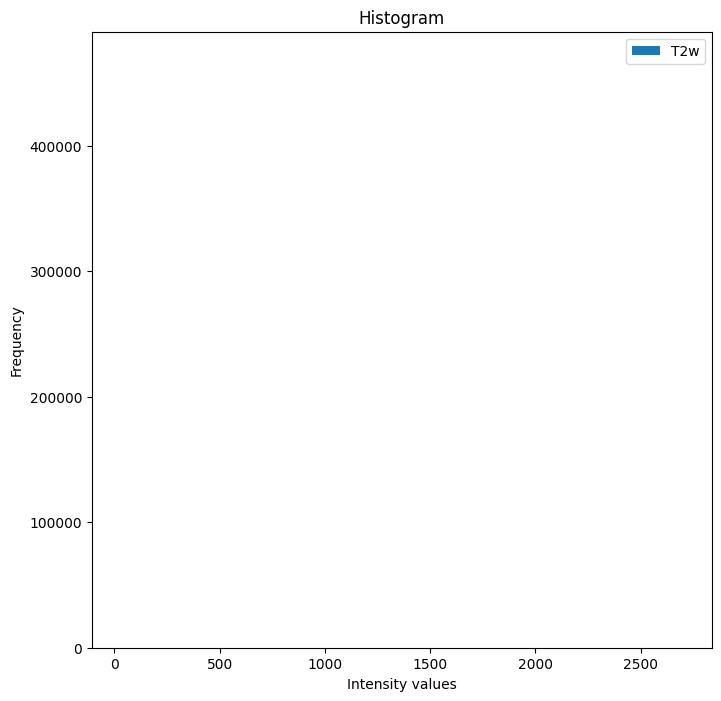

In [46]:
#plotting the histogram
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.bar(train_ds[0]['image_bins'], train_ds[0]['image_hist'], label='T2w')
ax.set_title('Histogram')
ax.set_xlabel('Intensity values')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()


## Get Radiomic Features

In [8]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
from numpy import std,mean

In [9]:
data_list = []
for path in images_paths.values:
    files = {}
    image_name = path.split('/')[-1]
    files['image'] = path        
    data_list.append(files)


In [20]:
def delete_black_slices(image_path: str, threshold: float = 0.5):
    image = sitk.ReadImage(image_path)
    
    data = sitk.GetArrayFromImage(image)
    img_std = std(data, keepdims=False)
    std_per_slice_axis1 = std(data, axis=(1, 2), keepdims=False)
    std_per_slice_axis2 = std(data, axis=(0, 2), keepdims=False)
    std_per_slice_axis3 = std(data, axis=(0, 1), keepdims=False)

    img_mean = mean(data, keepdims=False)
    mean_per_slice_axis1 = mean(data, axis=(1, 2), keepdims=False)
    mean_per_slice_axis2 = mean(data, axis=(0, 2), keepdims=False)
    mean_per_slice_axis3 = mean(data, axis=(0, 1), keepdims=False)

    mask_axis1 = (std_per_slice_axis1 > threshold * img_std) & (mean_per_slice_axis1 > threshold * img_mean)
    mask_axis2 = (std_per_slice_axis2 > threshold * img_std) & (mean_per_slice_axis2 > threshold * img_mean)
    mask_axis3 = (std_per_slice_axis3 > threshold * img_std) & (mean_per_slice_axis3 > threshold * img_mean)

    mask = np.full(data.shape, False)

    mask[np.ix_(mask_axis1, mask_axis2, mask_axis3)] = True
    # mask[mask_axis1, mask, :] = True
    # mask[:,mask_axis2,:] = True
    # mask[:,:,mask_axis3] = True
    masked_image = data[mask_axis1, :, :]
    masked_image = data[:, mask_axis2, :]
    masked_image = data[:, :, mask_axis3]
    
    
    #convert mask to simpleitk image
    mask = sitk.GetImageFromArray(mask.astype(np.uint8))
    mask.CopyInformation(image)

    sitk.WriteImage(mask, "Prostate_Cancer_TFM/Data_Analysis/EHRtemporalVariability/tmp_mask_radiomics/tmp_mask.nii.gz")
    return mask, masked_image


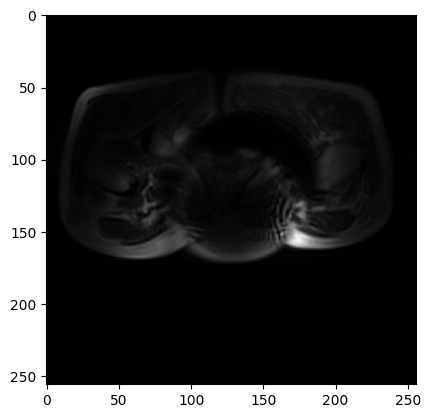

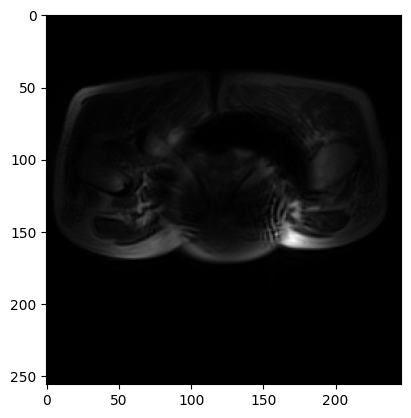

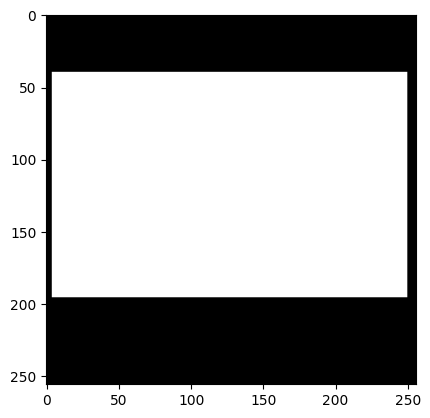

In [12]:
# Read Image using SimpleITK


image = sitk.ReadImage(images_paths[107])

#plot the image
plt.imshow(sitk.GetArrayFromImage(image)[5,:,:], cmap='gray')
plt.show()

#Apply tresholding to delete black zones with SimpleITK filters
mask, filtered_image = delete_black_slices(image, threshold=0.2)

plt.imshow(filtered_image[5,:,:], cmap='gray')
plt.show()

#plot the mask
plt.imshow(sitk.GetArrayFromImage(mask)[5,:,:], cmap='gray')
plt.show()

#save mask as temporal file
sitk.WriteImage(mask, "Prostate_Cancer_TFM/Data_Analysis/EHRtemporalVariability/tmp_mask_radiomics/tmp_mask.nii.gz")

#save image as temporal file
#sitk.WriteImage(image, "Prostate_Cancer_TFM/Data_Analysis/EHRtemporalVariability/tmp_mask_radiomics/tmp_image.nii.gz")



In [14]:
#Extracting radiomics features
extractor = RadiomicsFeatureExtractor()

features = extractor.execute( "Prostate_Cancer_TFM/Data_Analysis/EHRtemporalVariability/tmp_mask_radiomics/tmp_image.nii.gz", "Prostate_Cancer_TFM/Data_Analysis/EHRtemporalVariability/tmp_mask_radiomics/tmp_mask.nii.gz")
features

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


OrderedDict([('diagnostics_Versions_PyRadiomics', 'v3.0.1'),
             ('diagnostics_Versions_Numpy', '1.26.3'),
             ('diagnostics_Versions_SimpleITK', '2.3.1'),
             ('diagnostics_Versions_PyWavelet', '1.6.0'),
             ('diagnostics_Versions_Python', '3.10.13'),
             ('diagnostics_Configuration_Settings',
              {'minimumROIDimensions': 2,
               'minimumROISize': None,
               'normalize': False,
               'normalizeScale': 1,
               'removeOutliers': None,
               'resampledPixelSpacing': None,
               'interpolator': 'sitkBSpline',
               'preCrop': False,
               'padDistance': 5,
               'distances': [1],
               'force2D': False,
               'force2Ddimension': 0,
               'resegmentRange': None,
               'label': 1,
               'additionalInfo': True}),
             ('diagnostics_Configuration_EnabledImageTypes', {'Original': {}}),
             ('diag

In [17]:
for key, value in features.items():
    print(f"{key}: {value}")

diagnostics_Versions_PyRadiomics: v3.0.1
diagnostics_Versions_Numpy: 1.26.3
diagnostics_Versions_SimpleITK: 2.3.1
diagnostics_Versions_PyWavelet: 1.6.0
diagnostics_Versions_Python: 3.10.13
diagnostics_Configuration_Settings: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
diagnostics_Configuration_EnabledImageTypes: {'Original': {}}
diagnostics_Image-original_Hash: 88dec98a4413aada6635dd67e643081e384182d2
diagnostics_Image-original_Dimensionality: 3D
diagnostics_Image-original_Spacing: (1.4843800067901611, 1.4843800067901611, 5.5)
diagnostics_Image-original_Size: (256, 256, 60)
diagnostics_Image-original_Mean: 63.41800206502278
diagnostics_Image-original_Minimum: 0.0
diagnostics_Image-original_Maximum: 10

In [22]:
import os
import threading
import numpy as np
import pandas as pd
import SimpleITK as sitk
from radiomics import featureextractor as RadiomicsFeatureExtractor

def calculate_radiomics(case):
    threading.current_thread().name = case["ID"]

    if os.path.isfile(params):
        extractor = RadiomicsFeatureExtractor(params)
    else:  # Parameter file not found, use hardcoded settings instead
        settings = {}
        settings["binWidth"] = 25
        settings["resampledPixelSpacing"] = None
        settings["interpolator"] = sitk.sitkBSpline
        settings["enableCExtensions"] = True
        extractor = RadiomicsFeatureExtractor(**settings)

    print(
        f"Processing Patient {case['ID']} (Image: {case['Image']}, Mask: {case['Mask']})"
    )

    image = case["Image"]
    mask_,masked_image = delete_black_slices(image, threshold=0.2)

    mask = "Prostate_Cancer_TFM/Data_Analysis/EHRtemporalVariability/tmp_mask_radiomics/tmp_mask.nii.gz"
    mask = sitk.ReadImage(mask)
    values = np.unique(sitk.GetArrayFromImage(mask))
    # Uncomment if you want to check the number and values of all labels in the mask
    # print(values)
    values = np.array([1])  # Specify the values of labels of interest
    # Uncomment if you want to analyse all labels of mask
    # values = np.delete(values, 0)
    mask = "Prostate_Cancer_TFM/Data_Analysis/EHRtemporalVariability/tmp_mask_radiomics/tmp_mask.nii.gz"
    patient = pd.Series()
    patient.name = case["ID"]
    for label in values:
        label = int(label)
        print(
            f"Processing Patient {case['ID']} (Image: {case['Image']}, Mask: {mask}, Label: {label})"
        )
        if (image is not None) and (mask is not None):
            try:
                result = pd.Series(extractor.execute(image, mask, label))
            except Exception as e:
                print("FEATURE EXTRACTION FAILED:", str(e))
                result = pd.Series()
        else:
            print("FEATURE EXTRACTION FAILED: Missing Image and/or Mask")
            result = pd.Series()

        result.name = case["ID"]
        result = result.add_prefix(f"label{label}_")
        patient = patient.append(result)

    return patient

In [21]:
import logging  # to track running
import os  # help us load files and deal with paths
from multiprocessing import cpu_count, Pool
import threading
import pandas as pd  # for reading and writing tables
import SimpleITK as sitk
import radiomics  # radiomics package
from radiomics import featureextractor
import numpy as np
import pandas as pd

[{'image': '/mnt/ceib/datalake/FISABIO_datalake/p0042021/sub-000063/ses-000063/mim-mr/anat/sub-000063_ses-000063_acq-fse_run-3_bp-p_vp-sag_T2w.nii.gz'},
 {'image': '/mnt/ceib/datalake/FISABIO_datalake/p0042021/sub-000063/ses-000063/mim-mr/anat/sub-000063_ses-000063_acq-fse_run-6_bp-p_vp-ax_T2w.nii.gz'},
 {'image': '/mnt/ceib/datalake/FISABIO_datalake/p0042021/sub-000063/ses-000063/mim-mr/anat/sub-000063_ses-000063_acq-fse_run-8_bp-p_vp-ax_T2w.nii.gz'},
 {'image': '/mnt/ceib/datalake/FISABIO_datalake/p0042021/sub-000066/ses-000066/mim-mr/anat/sub-000066_ses-000066_acq-fse_run-5_bp-p_vp-sag_T2w.nii.gz'},
 {'image': '/mnt/ceib/datalake/FISABIO_datalake/p0042021/sub-000066/ses-000066/mim-mr/anat/sub-000066_ses-000066_acq-fse_run-8_bp-p_vp-ax_T2w.nii.gz'},
 {'image': '/mnt/ceib/datalake/FISABIO_datalake/p0042021/sub-000066/ses-000066/mim-mr/anat/sub-000066_ses-000066_acq-fse_run-3_bp-p_vp-cor_T2w.nii.gz'},
 {'image': '/mnt/ceib/datalake/FISABIO_datalake/p0042021/sub-000066/ses-000066/mim-mr

In [ ]:
data = pd.read_csv("/home/jaalzate/Tartaglia/Prostate_Tartaglia/codes/partition_1.csv")
df = data[["Unnamed: 0", "patient_id", "filepath_t2w_nifti", "filepath_label_gland"]]
df.columns = ["ID", "subject", "Image", "Mask"]

df["ID"] = ["s_" + str(i) for i in df["ID"]]
# df['ID_subject']=['s_'+str(i) for i in df['ID_subject']]
df["Image"] = [Path(path) for path in df["Image"]]
df["Mask"] = [Path(path) for path in df["Mask"]]


df.to_csv("Picai_wholegland_radiomics.csv")
# pd.read_csv('/home/jaalzate/Tartaglia/Prostate_Tartaglia/Radiomics/Picai_wholegland_radiomics.csv')

outPath = "/home/jaalzate/Tartaglia/Prostate_Tartaglia/Radiomics"
## Rename following files with the selected masks
inputCSV = os.path.join(outPath, "Picai_wholegland_radiomics.csv")
outputFilepath = os.path.join(outPath, "Picai_wholegland_radiomics_features_both.csv")
outputSummary = os.path.join(outPath, "Picai_wholegland_radiomics_summary_both.csv")
progress_filename = os.path.join(outPath, "Picai_wholegland_radiomics_log_both.txt")
params = os.path.join(outPath, "Params.yaml")

In [ ]:
# Import required libraries (ensure that you have imported all necessary modules)
import pandas as pd
from multiprocessing import Pool, cpu_count

# Assuming 'radiomics' and 'rLogger' are already imported and configured elsewhere in your code.
print("pyradiomics version:", radiomics.__version__)
print("Loading CSV")

try:
    # Use pandas to read and transpose ('.T') the input data
    # The transposition is needed so that each column represents one test case
    # This is easier for iteration over the input cases.
    flists = pd.read_csv(inputCSV).T
except Exception as e:
    print("CSV READ FAILED:", str(e))
    exit(-1)
print("Loading Done")
print("Patients:", len(flists.columns))

col_list = []
for col in flists:
    col_list.append(flists[col])

pool = Pool(processes=(cpu_count() - 1))
l_results = pool.map(run, col_list)
pool.close()
pool.join()
# Merge results in one df
results = pd.DataFrame()
for result in l_results:
    results = results.join(result, how="outer")
# General info and features in two files
# Creating an only-features CSV makes R loading easier
results = results.T
info = results.filter(regex="general", axis=1).columns
print(info)
summary = results[info]
results = results.drop(info, axis=1)

print("Extraction complete, writing CSVs")

results.to_csv(outputFilepath, na_rep="NaN")
print("Features CSV writing complete")
summary.to_csv(outputSummary, na_rep="NaN")
print("Summary CSV writing complete")

In [24]:
# Print the number of features extracted
print(f"Number of features extracted: {len(features)}")

Number of features extracted: 129


In [25]:
features

OrderedDict([('diagnostics_Versions_PyRadiomics', 'v3.0.1'),
             ('diagnostics_Versions_Numpy', '1.26.3'),
             ('diagnostics_Versions_SimpleITK', '2.3.1'),
             ('diagnostics_Versions_PyWavelet', '1.6.0'),
             ('diagnostics_Versions_Python', '3.10.13'),
             ('diagnostics_Configuration_Settings',
              {'minimumROIDimensions': 2,
               'minimumROISize': None,
               'normalize': False,
               'normalizeScale': 1,
               'removeOutliers': None,
               'resampledPixelSpacing': None,
               'interpolator': 'sitkBSpline',
               'preCrop': False,
               'padDistance': 5,
               'distances': [1],
               'force2D': False,
               'force2Ddimension': 0,
               'resegmentRange': None,
               'label': 1,
               'additionalInfo': True}),
             ('diagnostics_Configuration_EnabledImageTypes', {'Original': {}}),
             ('diag